In [1]:
import os
import torch
import fairseq
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import librosa
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model

ModuleNotFoundError: No module named 'fairseq'

In [2]:
main_folder_path = "E:\wav2vec\prc_data"

min_duration = 0.6

model_name = "facebook/wav2vec2-large-960h"
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
model = Wav2Vec2Model.from_pretrained(model_name)



def extract_features(audio_file_path):
    audio, sr = librosa.load(audio_file_path, sr=16000)
    duration = librosa.get_duration(y=audio, sr=sr)
    if duration < min_duration:
        pad_samples = int((min_duration - duration) * sr)
        audio = np.pad(audio, (0, pad_samples), mode='constant')
    elif duration > min_duration:
        audio = audio[:int(min_duration * sr)]
    
    audio_reshaped = np.reshape(audio, (1, -1))
        
    input_values = feature_extractor(audio_reshaped, return_tensors="pt", padding=True, 
                                 feature_size=1, sampling_rate=16000 ).input_values
    hidden_states = model(input_values).last_hidden_state
    features_last_cnn_layer = model(input_values).extract_features
   
    return hidden_states, features_last_cnn_layer


C:\Users\ijazhaq\AppData\Local\anaconda3\envs\wav2vec\lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ijazhaq\.cache\huggingface\hub\models--facebook--wav2vec2-large-960h. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at 

In [3]:
all_hidden_states_f=[]
all_features_last_cnn_layer_f=[]
all_labels = []

# Iterate through each subfolder and its contents
for root, dirs, files in os.walk(main_folder_path):
    for folder_name in dirs:
        folder_path = os.path.join(root, folder_name)
        # Iterate through each audio file in the subfolder
        for audio_file_name in os.listdir(folder_path):
            audio_file_path = os.path.join(folder_path, audio_file_name)
            if audio_file_name.endswith(".wav"):  # Adjust the extension if needed
                # Extract features and append to lists
                hidden_states_f, features_last_cnn_layer_f = extract_features(audio_file_path)
                
                
                all_hidden_states_f.append(hidden_states_f)
                all_features_last_cnn_layer_f.append(features_last_cnn_layer_f)
                all_labels.append(folder_name)
                
                # Print the file name along with the shape of the tensor
                print(f"File name: {audio_file_name}, Shape of tensor {len(all_hidden_states_f) - 1}: {hidden_states_f.shape}")

File name: 0_01_0.wav, Shape of tensor 0: torch.Size([1, 29, 1024])
File name: 0_01_13.wav, Shape of tensor 1: torch.Size([1, 29, 1024])
File name: 0_01_15.wav, Shape of tensor 2: torch.Size([1, 29, 1024])
File name: 0_01_17.wav, Shape of tensor 3: torch.Size([1, 29, 1024])
File name: 0_01_29.wav, Shape of tensor 4: torch.Size([1, 29, 1024])
File name: 0_01_35.wav, Shape of tensor 5: torch.Size([1, 29, 1024])
File name: 0_01_36.wav, Shape of tensor 6: torch.Size([1, 29, 1024])
File name: 0_01_40.wav, Shape of tensor 7: torch.Size([1, 29, 1024])
File name: 0_01_41.wav, Shape of tensor 8: torch.Size([1, 29, 1024])
File name: 0_01_9.wav, Shape of tensor 9: torch.Size([1, 29, 1024])
File name: 0_02_20.wav, Shape of tensor 10: torch.Size([1, 29, 1024])
File name: 0_02_22.wav, Shape of tensor 11: torch.Size([1, 29, 1024])
File name: 0_02_25.wav, Shape of tensor 12: torch.Size([1, 29, 1024])
File name: 0_02_30.wav, Shape of tensor 13: torch.Size([1, 29, 1024])
File name: 0_02_35.wav, Shape of

In [4]:
from sklearn.svm import SVC
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import accuracy_score

all_hidden_states_f_tensor = torch.cat(all_hidden_states_f, dim=0)
all_hidden_states_f_array = all_hidden_states_f_tensor.detach().numpy()

# Step 1: Prepare the data
# Reshape the audio features array to fit the SVM classifier
X_train = all_hidden_states_f_array.reshape(-1, 29 * 1024)  # Assuming 29 time steps and 1024 features per time step
# Ensure that labels are in suitable format
y_train = all_labels

# Step 2: Train the SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)

# Step 3: Evaluate the SVM classifier
# Make predictions on the training data
y_pred_train = svm_classifier.predict(X_train)

# Calculate accuracy on the training data
accuracy_train = accuracy_score(y_train, y_pred_train)
print("Training Accuracy:", accuracy_train)

Training Accuracy: 1.0


Cluster 0 : 11
Cluster 1 : 30
Cluster 2 : 22
Cluster 3 : 53
Cluster 4 : 26
Cluster 5 : 18


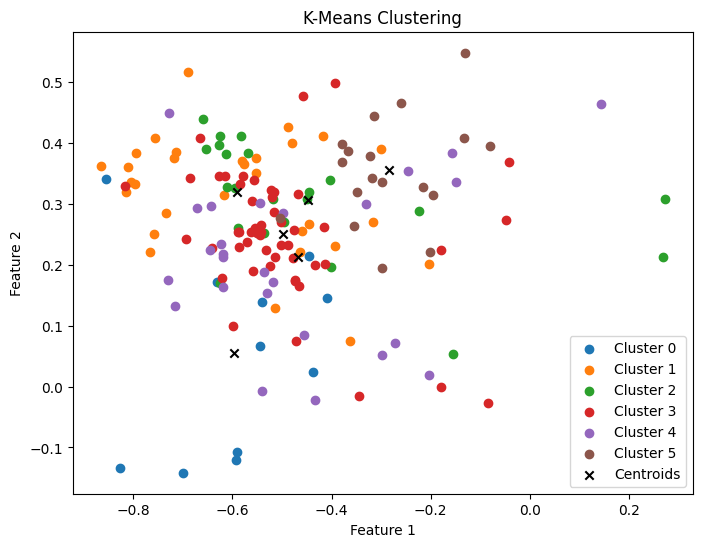

In [5]:
# Step 4: Perform k-means clustering
k = 6  # Number of clusters (you can adjust this)
kmeans = KMeans(n_clusters=k)
kmeans.fit(X_train)
cluster_labels = kmeans.labels_

# Optionally, you can analyze the cluster assignments
# For example, you can print the number of samples in each cluster
for i in range(k):
    print("Cluster", i, ":", sum(cluster_labels == i))
    
plt.figure(figsize=(8, 6))
for i in range(k):
    plt.scatter(X_train[cluster_labels == i, 0], X_train[cluster_labels == i, 1], label=f'Cluster {i}')

# Plot the centroids
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', color='black', label='Centroids')

plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

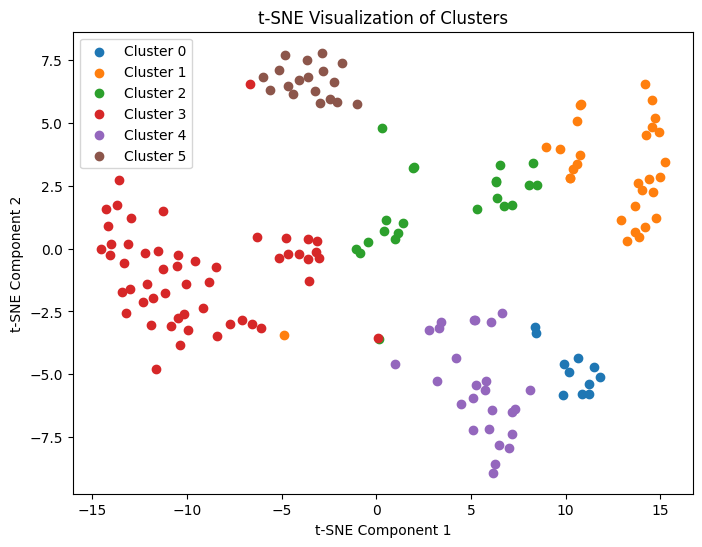

In [6]:
from sklearn.manifold import TSNE

# Initialize t-SNE model
tsne = TSNE(n_components=2, random_state=42)

# Fit t-SNE model to the data
X_train_tsne = tsne.fit_transform(X_train)

# Plot the t-SNE embeddings
plt.figure(figsize=(8, 6))
for i in range(k):
    plt.scatter(X_train_tsne[cluster_labels == i, 0], X_train_tsne[cluster_labels == i, 1], label=f'Cluster {i}')

plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()